# AlexNet vs ResNet Performance

## AlexNet baseline

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
 # Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [3]:
def get_train_valid_loader(data_dir,
                               batch_size,
                               augment,
                               random_seed,
                               valid_size=0.1,
                               shuffle=True):
        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        valid_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
        ])
        if augment:
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
            ])

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=train_transform,
        )

        valid_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=valid_transform,
        )

        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(random_seed)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler)

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, sampler=valid_sampler)

        return train_loader, valid_loader


def get_test_loader(data_dir,
                        batch_size,
                        shuffle=True):
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )

        # define transform
        transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

        dataset = datasets.CIFAR10(
            root=data_dir, train=False,
            download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # CIFAR10 dataset 
train_loader, valid_loader = get_train_valid_loader(data_dir = './data', batch_size = 64, augment = False, random_seed = 1)

test_loader = get_test_loader(data_dir = './data', batch_size = 64)

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#alexnet(https://www.digitalocean.com/community/tutorials/alexnet-pytorch)
class AlexNet(nn.Module):
        def __init__(self, num_classes=10):
            super(AlexNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer5 = nn.Sequential(
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(9216, 4096),
                nn.ReLU())
            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, num_classes))

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
    

In [5]:


num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

base_model_alex = AlexNet(num_classes).to(device)

def train(model, train_loader, num_epochs, learning_rate, val_loader, device):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9)  

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0
        
        for images, labels in train_loader:  
            # Move tensors to the configured device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Compute average training loss for the epoch
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Compute accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {100 * correct / total:.2f}%')

    return train_losses, val_losses

In [6]:
alex_train_loss, alex_val_loss = train(base_model_alex, train_loader, num_epochs, learning_rate, valid_loader, device)

Epoch [1/20], Training Loss: 1.3975
Validation Loss: 1.0933, Accuracy: 61.42%
Epoch [2/20], Training Loss: 0.9847
Validation Loss: 0.8641, Accuracy: 68.76%
Epoch [3/20], Training Loss: 0.8228
Validation Loss: 0.8010, Accuracy: 72.04%
Epoch [4/20], Training Loss: 0.7200
Validation Loss: 0.8968, Accuracy: 68.82%
Epoch [5/20], Training Loss: 0.6560
Validation Loss: 0.7222, Accuracy: 74.26%
Epoch [6/20], Training Loss: 0.6011
Validation Loss: 0.6744, Accuracy: 76.50%
Epoch [7/20], Training Loss: 0.5567
Validation Loss: 0.7982, Accuracy: 73.68%
Epoch [8/20], Training Loss: 0.5235
Validation Loss: 0.6495, Accuracy: 77.46%
Epoch [9/20], Training Loss: 0.4858
Validation Loss: 0.5847, Accuracy: 80.34%
Epoch [10/20], Training Loss: 0.4546
Validation Loss: 0.6380, Accuracy: 78.38%
Epoch [11/20], Training Loss: 0.4248
Validation Loss: 0.6428, Accuracy: 78.08%
Epoch [12/20], Training Loss: 0.4043
Validation Loss: 0.5331, Accuracy: 81.68%
Epoch [13/20], Training Loss: 0.3953
Validation Loss: 0.5975,

In [7]:
def test(model, loader):
    with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs

            print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

In [8]:
test(base_model_alex, test_loader)

Accuracy of the network on the 10000 test images: 77.79 %


## ResNet Baseline
code is from: https://www.digitalocean.com/community/tutorials/writing-resnet-from-scratch-in-pytorch

In [9]:
def data_loader_resnet(data_dir,
                    batch_size,
                    random_seed=42,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                normalize,
        ])

        if test:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=True, transform=transform,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=transform,
        )

        valid_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=transform,
        )

        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler)

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)


train_loader_resnet, valid_loader_resnet = data_loader_resnet(data_dir='./data', batch_size=64)

test_loader_resnet = data_loader_resnet(data_dir='./data', batch_size=64, test=True)

In [10]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

In [11]:
class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 10):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

In [12]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.01

resnet_baseline_model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_baseline_model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  
#Train the model
total_step = len(train_loader_resnet)

In [13]:
import gc
from torch.cuda.amp import autocast, GradScaler
def train_resnet(model, num_epochs, criterion, learning_rate, val_loader, train_load, optimizer, device):
    
    # Enable cuDNN benchmarking for optimization
    torch.backends.cudnn.benchmark = True
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    # Enable Mixed Precision Training
    scaler = torch.amp.GradScaler()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for images, labels in train_load:  
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed precision training
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backpropagation with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()
            del images, labels, outputs
        
        # Step the learning rate scheduler
        scheduler.step()

        # Compute average training loss per epoch
        avg_train_loss = epoch_loss / len(train_load)
        train_losses.append(avg_train_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()  # Accumulate scalar values
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                del images, labels, outputs

        # Compute average validation loss per epoch
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {100 * correct / total:.2f}%')

    return train_losses, val_losses

In [14]:
resnet_train_loss, resnet_val_loss = train_resnet(resnet_baseline_model, num_epochs, criterion, learning_rate, valid_loader_resnet, train_loader_resnet, optimizer, device)

Epoch [1/20], Training Loss: 1.4686
Validation Loss: 1.2988, Accuracy: 51.40%
Epoch [2/20], Training Loss: 0.8819
Validation Loss: 1.2773, Accuracy: 59.92%
Epoch [3/20], Training Loss: 0.6616
Validation Loss: 0.7467, Accuracy: 74.94%
Epoch [4/20], Training Loss: 0.5348
Validation Loss: 0.5763, Accuracy: 80.32%
Epoch [5/20], Training Loss: 0.4539
Validation Loss: 0.6654, Accuracy: 77.48%
Epoch [6/20], Training Loss: 0.3814
Validation Loss: 0.8043, Accuracy: 75.16%
Epoch [7/20], Training Loss: 0.3219
Validation Loss: 0.5771, Accuracy: 81.14%
Epoch [8/20], Training Loss: 0.2708
Validation Loss: 0.5148, Accuracy: 83.56%
Epoch [9/20], Training Loss: 0.2373
Validation Loss: 0.6213, Accuracy: 81.18%
Epoch [10/20], Training Loss: 0.2105
Validation Loss: 0.6370, Accuracy: 80.84%
Epoch [11/20], Training Loss: 0.1777
Validation Loss: 0.7386, Accuracy: 77.74%
Epoch [12/20], Training Loss: 0.1476
Validation Loss: 0.5612, Accuracy: 83.62%
Epoch [13/20], Training Loss: 0.1265
Validation Loss: 0.7411,

In [15]:
test(resnet_baseline_model, test_loader_resnet)

Accuracy of the network on the 10000 test images: 82.75 %


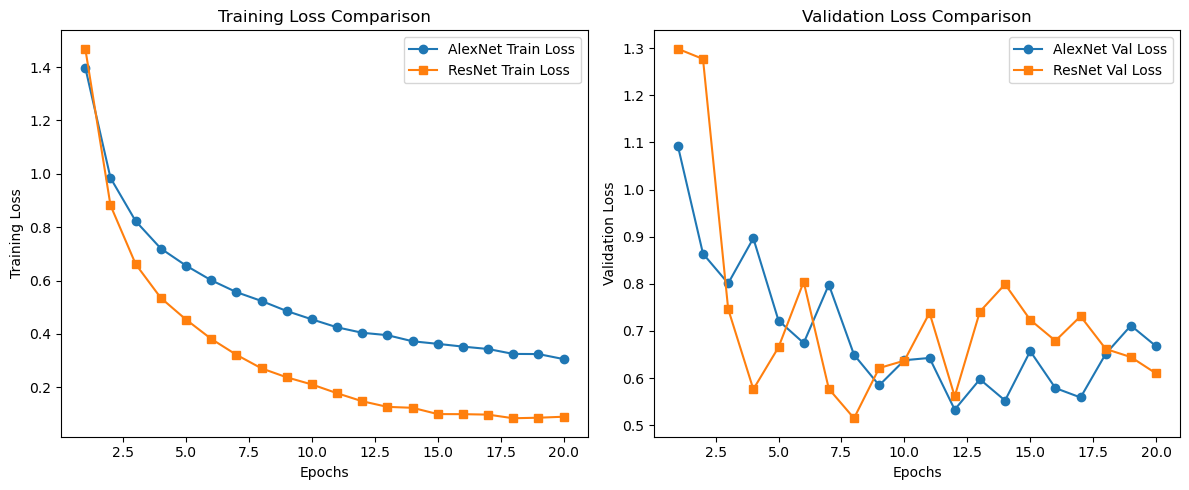

In [16]:
import matplotlib.pyplot as plt

# Ensure tensors are moved to CPU and converted to lists if necessary
alex_train_loss = [loss.item() if hasattr(loss, 'item') else loss for loss in alex_train_loss]
alex_val_loss = [loss.item() if hasattr(loss, 'item') else loss for loss in alex_val_loss]
resnet_train_loss = [loss.item() if hasattr(loss, 'item') else loss for loss in resnet_train_loss]
resnet_val_loss = [loss.item() if hasattr(loss, 'item') else loss for loss in resnet_val_loss]

# Generate training and validation loss comparison plots
plt.figure(figsize=(12, 5))

# Training Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(alex_train_loss) + 1), alex_train_loss, label='AlexNet Train Loss', marker='o')
plt.plot(range(1, len(resnet_train_loss) + 1), resnet_train_loss, label='ResNet Train Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()

# Validation Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(alex_val_loss) + 1), alex_val_loss, label='AlexNet Val Loss', marker='o')
plt.plot(range(1, len(resnet_val_loss) + 1), resnet_val_loss, label='ResNet Val Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()

# Display the plots
plt.tight_layout()

# Save the plot
plt.savefig("training_vs_validation_loss.png", dpi=300)  # Saves as PNG with high resolution

# Show the plot
plt.show()

In [17]:
torch.save(base_model_alex, 'base_model_alex.pth')
torch.save(resnet_baseline_model, 'base_model_resnet.pth')